# A look at influenza

## the plan

- A look at the pathogen: [influenza A](https://en.wikipedia.org/wiki/Influenza_A_virus)
  - a pathogen evolving rapidly and under strong selection pressure
- Download data and metadata
  - quick inspection and quality control
- Building a multiple sequence alignment
  - inspecting and trimming the alignment.
  - looking for signatures of selection
- Building a phylogenetic tree
  - building a tree from the alignment
  - manipulating trees with Biopython
  - augmenting the tree with metadata
  - simple parsimonious ancestral state reconstruction: Fitch's algorithm
  - rooted vs unrooted trees: the problem of picking a root


# Influenza A virus

- A segmented, negative-sense RNA virus
- 8 segments of RNA, ~13.5 kb in total

![fluA](assets/fluA.png)

- classified into subtypes based on two surface proteins:
  - hemagglutinin (HA), involved in binding to host cells
  - neuraminidase (NA), involved in the release of new virions
  - both are targets for the immune system
- Rapidly evolving virus (~$4 \times 10^{-3}$ substitutions per site per year on fast-evolving genes)
  - high mutation rate
  - frequent reassortment
- Infects a wide range of hosts
  - humans, birds, pigs...
- Both seasonal circulation and pandemic outbreaks

![flu pandemics](assets/flu_pandemics.png)

[(from this presentation)](https://neherlab.org/202303_RoyalSociety.html#/).

We'll focus on the H3N2 subtype:
- first emerging in 1968 (Hong Kong flu) via reassortment with avian strain.

To get a sense of the data, here is a phylogenetic tree for the HA gene of H3N2 influenza A viruses for the last 12 years of evolution: [nextstrain H3N2 tree](https://nextstrain.org/seasonal-flu/h3n2/ha/12y)
- ladder-like structure
- fast substitution rate
- let's look at the annotations on the segment: HA1 and HA2 encode the receptor binding domain and the fusion peptide, respectively. Cleaved post-translationally by host proteases.

# Downloading the dataset

Head to the [NCBI virus database](https://www.ncbi.nlm.nih.gov/labs/virus/) and search for "influenza A" virus

- select _segment 4_: [hemagglutinin](https://en.wikipedia.org/wiki/Hemagglutinin_(influenza)) (HA)
- under "genotype" select subtype : H3N2
- should be ~1700 bp long, you can optionally impose a minimum length filter of 1700 bp
- optionally, you can also require that the sequence does not contain any ambiguous bases.

This will still give you too many sequences for a quick analysis (~60k) so we will need to sub-sample the dataset

- select "download" and choose "nucleotide" (fasta) format
- select "download a randomized subset"
  - stratify by "collection year", and select 5 samples per category
  - other than `Accession`, `GenBank title` and `Collection Date`, also add `Country` to the fasta definition line. This will add metadata that we will analyze later.

This should give you a file with ~300 sequences.

# Preliminary quality control: a look at the fasta file

- how many sequences do you have?
- how long are they on average?
- how does the description line look like?
- can you parse the metadata from the description line? What is the distribution of sampling dates? And of countries?
- Are there sequences with many ambiguous bases `N`?

In [37]:
from Bio import SeqIO
import pandas as pd
import numpy as np

fname = "data/h3n2.fa"

# parse metadata
entries = []
for r in SeqIO.parse(fname, "fasta"):
    # Extract the metadata from the description
    metadata = r.description.split("|")
    seq = r.seq
    # Extract the relevant fields
    entry = {
        "accession": r.id,
        "description": metadata[1].replace(",","."),
        "date": metadata[2],
        "country": metadata[3],
        "len": len(seq),
        "ambiguous": len(seq) - sum([seq.count(b) for b in ["A", "C", "G", "T"]]),
    }
    entries.append(entry)

# turn into pandas dataframe, parsing dates
metadata = pd.DataFrame(entries).set_index("accession")
metadata["date"] = pd.to_datetime(metadata["date"], format="ISO8601")
metadata["collection_year"] = metadata["date"].dt.year
# set country as a categorical variable, with order given by frequency
metadata["country"] = metadata["country"].astype("category")
metadata["country"] = metadata["country"].cat.reorder_categories(
    metadata["country"].value_counts().index.to_numpy(), ordered=True
)

# save the metadata DataFrame to a CSV file
metadata.to_csv("results/h3n2_metadata.csv")
# Show the first few rows of the metadata DataFrame
metadata

,description,date,country,len,ambiguous,collection_year
accession,,,,,,
CY039167.1,Influenza A virus (A/Hong Kong/HKU24/2004(H3N2...,2004-07-05,Hong Kong,1718,0,2004
CY002760.1,Influenza A virus (A/New York/68/2004(H3N2)) s...,2004-11-06,USA,1737,0,2004
CY118802.1,Influenza A virus (A/Malaysia/29711/2004(H3N2)...,2004-09-14,Malaysia,1734,0,2004
CY019157.1,Influenza A virus (A/New York/900/2004(H3N2)) ...,2004-12-22,USA,1722,0,2004
CY007403.1,Influenza A virus (A/Canterbury/23/2004(H3N2))...,2004-08-19,New Zealand,1717,0,2004
...,...,...,...,...,...,...
CY022938.1,Influenza A virus (A/Albany/1/1970(H3N2)) segm...,1970-01-01,USA,1731,0,1970
CY021085.1,Influenza A virus (A/Albany/2/1970(H3N2)) segm...,1970-01-01,USA,1730,0,1970
CY021117.1,Influenza A virus (A/Albany/6/1970(H3N2)) segm...,1970-01-01,USA,1724,0,1970


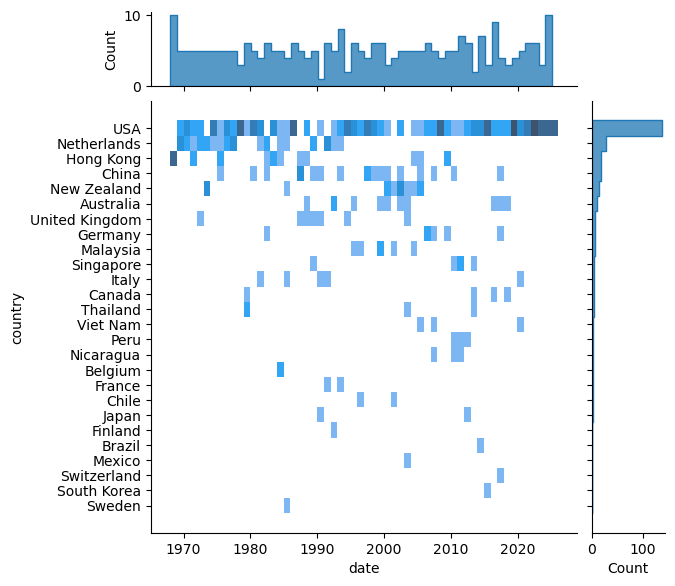

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.jointplot(
    data=metadata,
    x="date",
    y="country",
    kind="hist",
    marginal_ticks=True,
    binwidth=(365, None),
    marginal_kws=dict(element="step"),
)
plt.show()

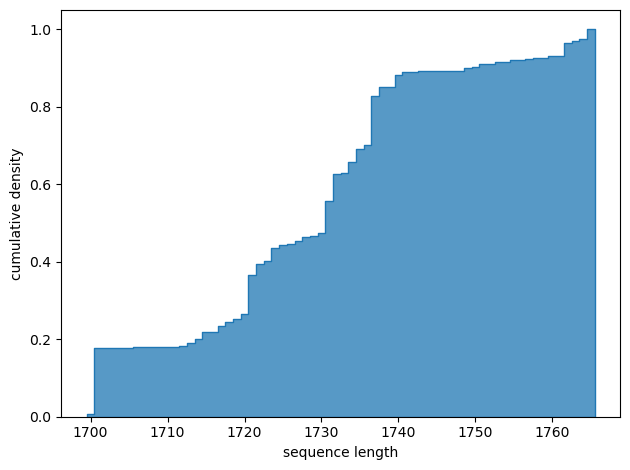

In [39]:
sns.histplot(
    data=metadata,
    x="len",
    cumulative=True,
    stat="density",
    discrete=True,
    element="step",
)
plt.xlabel("sequence length")
plt.ylabel("cumulative density")
plt.tight_layout()
plt.show()

In [40]:
# number of ambiguous bases
print("Number of sequences with ambiguous bases:")
metadata["ambiguous"].value_counts().sort_index()

Number of sequences with ambiguous bases:


ambiguous
0    276
1     12
2      1
Name: count, dtype: int64

# Building a multiple sequence alignment

After preliminary quality control, we can align all sequences. We will not align all sequences to a reference, but rather align all sequences to each other in a multiple sequence alignment.

We will use [MAFFT](https://mafft.cbrc.jp/alignment/software/) for this. This is a fast and accurate multiple sequence alignment program. It scales well to relatively large datasets, and uses different algorithms, including Fast Fourier Transform (FFT) to speed up alignment.

It can be installed via conda:
```bash
conda install bioconda::mafft
```

And can be run from the command line:
```bash
mafft --auto <input> > <output>
```

## Inspecting the alignment

- you can visualize the alignment with your tool of choice. If you don't have one, you can use [AliView](https://ormbunkar.se/aliview/) for example.
- can you find the start-end of the coding region?
- are there any gaps in the alignment?
- are there sequences that do not align well and should be removed?
- polish the alignment if necessary (e.g. remove low-quality sequences) and trim the alignment to the coding region.
- is the diversity different in different parts of the alignment? What about amino-acid diversity?

In [41]:
from Bio import SeqIO, AlignIO, Seq

fname = "results/h3n2.aln.fa"
# Read the alignment file
alignment = AlignIO.read(fname, "fasta")
# Print the alignment object
print(alignment)

Alignment with 289 rows and 1765 columns
----------------------------catgaagactatcatt...--- CY039167.1
--caaaagcaggggataattttattaaccatgaagactatcatt...--- CY002760.1
---------------taattctattaaccatgaagactatcatt...--- CY118802.1
--------------------ctattaaccatgaagactatcatt...--- CY019157.1
-------------------------aaccatgaagactatcatt...--- CY007403.1
------------ggataattctattaaccatgaagactatcatt...--- OP840967.1
-----------------------------atgaagactatcatt...--- OP086610.1
agcaaaagcaggggatactttcattaatcatgaaaattgttatt...act OP364489.1
------------ggataattctatcaaccatgagaaccatcatt...--- OR266751.1
------------ggataattctattaaccatgaagactatcatt...--- OP842065.1
------------ggataattctattaaccatgaaggctatcatt...--- PV584740.1
------------ggataattctattaaccatgaaggctatcatt...--- PV509329.1
------------ggataattctattaaccatgaaggctatcatt...--- PV271092.1
------------ggataattctattaaccatgaaggctatcatt...--- PV510529.1
--cgaaagcaggggataattctattaaccatgaaggctatcatt...--- PV249837.1
------------ggataattctattaacc

In [42]:
# restrict the alignment to the coding region
start = 29
end = 1727
aln = alignment[:, start:end]

# delete columns where the consensus character is a gap

def get_consensus_sequence(aln):
    """
    Get the consensus sequence from an alignment.
    """
    from collections import Counter
    # get the length of the alignment
    L = aln.get_alignment_length()
    # create a list to store the consensus sequence
    cons_seq = []
    for l in range(L):
        # get the consensus character for this column
        column = aln[:, l]
        cons_char = Counter(column).most_common(1)[0][0]
        cons_seq.append(cons_char)
    return np.array(cons_seq)

def remove_columns(aln, column_mask):
    """
    Remove columns from the alignment based on a mask.
    modify the alignment in place.
    """
    # create a list to store the new alignment
    A = np.array(aln)
    A = A[:, column_mask]
    for idx, record in enumerate(aln):
        # set the sequence to the new sequence
        record.seq = Seq.Seq("".join(A[idx]))

# get the consensus sequence
cons_seq = get_consensus_sequence(aln)
# create a mask for the columns to keep
column_mask = np.array([c != "-" for c in cons_seq])
# remove the columns from the alignment
remove_columns(aln, column_mask)
# Print the new alignment
print(aln)
# Write the new alignment to a file
with open("results/h3n2_coding.aln.fa", "w") as f:
    SeqIO.write(aln, f, "fasta")


Alignment with 289 rows and 1698 columns
atgaagactatcattgctttgagctacattctatgtctggtttt...att CY039167.1
atgaagactatcattgctttgagctacattctatgtctggtttt...att CY002760.1
atgaagactatcattgctttgagctacattctatgtctggtttt...att CY118802.1
atgaagactatcattgctttgagctacattctatgtctggtttt...att CY019157.1
atgaagactatcattgctttgagctacattctatgtctggtttt...att CY007403.1
atgaagactatcattgctttgagctacattctatgtctggtttt...att OP840967.1
atgaagactatcattgctttgagcaacattctatgtcttgtttt...att OP086610.1
atgaaaattgttattgctttaagctatattttctgcctggcttt...att OP364489.1
atgagaaccatcattgttttgagccaaattctatatctgrtttt...att OR266751.1
atgaagactatcattgctttgagcaacattctatgtcttgtttt...att OP842065.1
atgaaggctatcattgctttgagcaacattctatgtcttgtttt...att PV584740.1
atgaaggctatcattgctttgagcaacattctatgtcttgtttt...att PV509329.1
atgaaggctatcattgctttgagcaacattctatgtcttgtttt...att PV271092.1
atgaaggctatcattgctttgagcaacattctatgtcttgtttt...att PV510529.1
atgaaggctatcattgctttgagcaacattctatgtcttgtttt...att PV249837.1
atgaaggctatcattgctttgagcaacat

In [43]:
def convert_to_aa_alignment(aln):
    """
    Convert a nucleotide alignment to an amino acid alignment.
    """
    # create a list to store the new alignment
    aa_aln = []
    for record in aln:
        # convert the sequence to an amino acid sequence
        aa_seq = record.seq.translate()
        # create a new SeqRecord object with the amino acid sequence
        aa_record = SeqIO.SeqRecord(
            seq=aa_seq,
            id=record.id,
            description=record.description,
        )
        aa_aln.append(aa_record)
    aa_aln = AlignIO.MultipleSeqAlignment(aa_aln)
    return aa_aln

# convert the alignment to an amino acid alignment
aa_aln = convert_to_aa_alignment(aln)
# Print the new alignment
print(aa_aln)
# Write the new alignment to a file
with open("results/h3n2.aa.aln.fa", "w") as f:
    SeqIO.write(aa_aln, f, "fasta")

Alignment with 289 rows and 566 columns
MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKT...ICI CY039167.1
MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKT...ICI CY002760.1
MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTVVKT...ICI CY118802.1
MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKT...ICI CY019157.1
MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKT...ICI CY007403.1
MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKT...ICI OP840967.1
MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKT...ICI OP086610.1
MKIVIALSYIFCLAFSQNLLGNENNAATLCLGHHAVPNGTMVKT...ICI OP364489.1
MRTIIVLSQILYLXFAQKLPGNDNNMATLCLGHHAVPNGTIVKT...ICI OR266751.1
MKTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKT...ICI OP842065.1
MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKT...ICI PV584740.1
MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKT...ICI PV509329.1
MKAIIALSNILCLVFAQKIPGNDDSTATLCLGHHAVPNGTIVKT...ICI PV271092.1
MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTVVKT...ICI PV510529.1
MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKT...ICI PV249837.1
MKAIIALSNILCLVFAQKIPGNDNSTATLC

## Diversity along the sequence

- look at how the diversity varies along the sequence. You can measure it in terms of non-consensus frequency or in terms of entropy.
- can you spot any patterns? What do you think is going on?

In [44]:
def non_consensus_frequency(aln):
    """
    Calculate the frequency of non-consensus characters in the alignment.
    """
    # turn the alignment into a numpy matrix
    A = np.array(aln)
    # get the consensus sequence
    cons_seq = get_consensus_sequence(aln)
    # calculate the frequency of non-consensus characters
    non_consensus = A != cons_seq
    non_cons_freq = non_consensus.mean(axis=0)
    return non_cons_freq

nc_freq = non_consensus_frequency(aln)

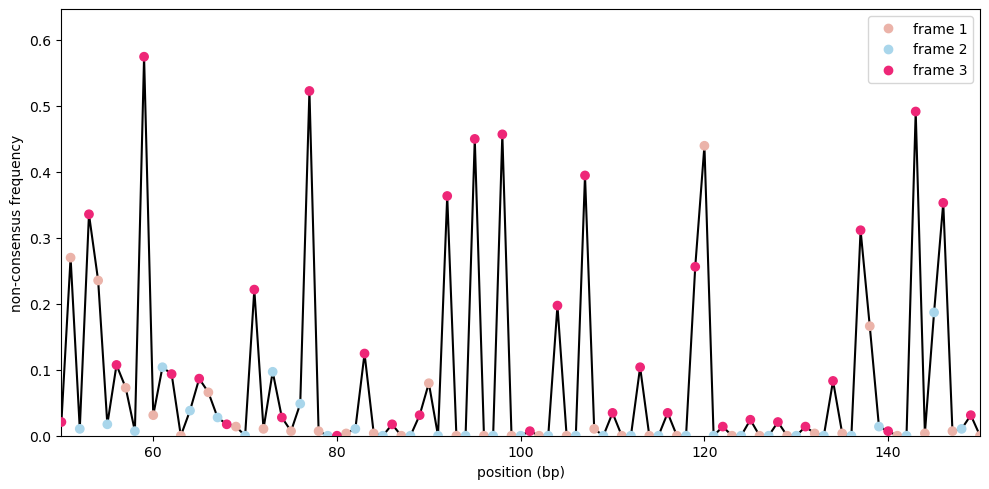

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(nc_freq, "k-")
# plot positions in different frames with different colors
x = np.arange(len(nc_freq))
frame_color = {
    0: "#EBB3A9",
    1: "#A9D6EB",
    2: "#EE2677",
}
colors = [frame_color[i] for i in x % 3]
plt.scatter(x, nc_freq, c=colors, zorder=3)
for idx, color in frame_color.items():
    plt.plot([], [], "o", color=color, label=f"frame {idx + 1}")
plt.legend()
plt.xlim(50, 150)
plt.xlabel("position (bp)")
plt.ylabel("non-consensus frequency")
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

We can indeed observe a pattern: there seems to be a pattern in the high-diversity sites. These are mostly sites that are located at the third position of a codon. These sites are often more free to mutate, as mutations in these sites are more likely to result in **synonymous mutations**.

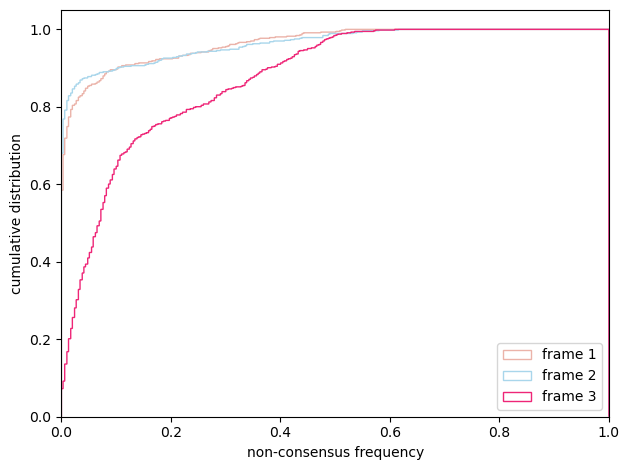

In [46]:
for idx, color in frame_color.items():
    plt.hist(
        nc_freq[x % 3 == idx],
        bins=np.linspace(0, 1, 1000),
        color=color,
        histtype="step",
        label=f"frame {idx + 1}",
        cumulative=True,
        density=True,
    )
plt.legend()
plt.xlabel("non-consensus frequency")
plt.ylabel("cumulative distribution")
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

The same can be measured in terms of entropy of the distribution of nucleotides at each position. This is a measure of diversity that is independent of the consensus sequence. It is defined as:
$$
H = - \sum_{i=1}^4 p_i \log(p_i)
$$
where $p_i$ is the frequency of nucleotide $i$ at a given position.

In [47]:
def get_alignment_entropy(aln):
    """
    Calculate the entropy of the alignment.
    """
    from scipy.stats import entropy
    from collections import Counter
    # turn the alignment into a numpy matrix
    A = np.array(aln)
    # get the length of the alignment
    L = A.shape[1]
    # create a list to store the entropy values
    entropies = []
    for l in range(L):
        # get the column for this position
        column = A[:, l]
        # calculate the frequency of each character
        counts = Counter(column).values()
        # calculate the entropy of the column
        p = np.array(list(counts))
        H = entropy(p, base=4)
        # append the entropy to the list
        entropies.append(H)
    # convert the list to a numpy array
    return np.array(entropies)

# calculate the entropy of the alignment
entropies = get_alignment_entropy(aln)


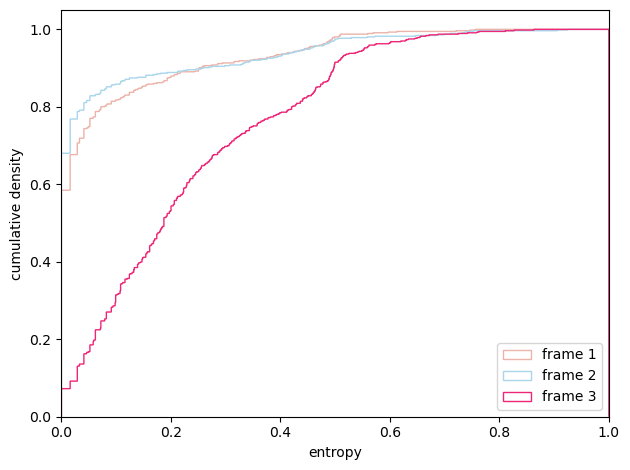

In [48]:
for idx, color in frame_color.items():
    plt.hist(
        entropies[x % 3 == idx],
        bins=np.linspace(0, 1, 1000),
        color=color,
        histtype="step",
        label=f"frame {idx + 1}",
        cumulative=True,
        density=True,
    )
plt.legend()
plt.xlabel("entropy")
plt.ylabel("cumulative density")
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

### Signatures of selection

More diversity in third-codon position is indicative of imbalance between the ratio of synonymous and non-synonymous mutations, which itself is a signature of selection. There are more rigorous measures of such imbalance, such as the [dN/dS ratio](https://en.wikipedia.org/wiki/Ka/Ks_ratio), which is the ratio of the rate of non-synonymous mutations to the rate of synonymous mutations.

But even from this simple measure, we can see that (unsurprisingly) the virus is under strong selection pressure.
- the virus mutates rapidly, and most mutations are lost due to purifying selection
- at the same time, the virus is under pressure to escape the immune system. This is especially true for the HA protein.

It is important to keep this in mind. Systems under selection often can violate some of the assumptions of evolutionary models, e.g. heterogeneity of rates of evolution, codon usage bias...


### Diversity along the sequence

The diversity is also not uniform along the sequence.

The HA gene is divided into two subunits that are cleaved post-translationally:

- HA1: head of the protein. Contains the receptor binding domain. More exposed to the immune system (primary target of antibodies).
- HA2: stem region of the protein. Contains the fusion peptide. Less exposed to the immune system.

These two domains are subject to different levels of selection pressure and consequent antigenic drift. This is reflected in the amino-acid level diversity of the two domains along the sequence.

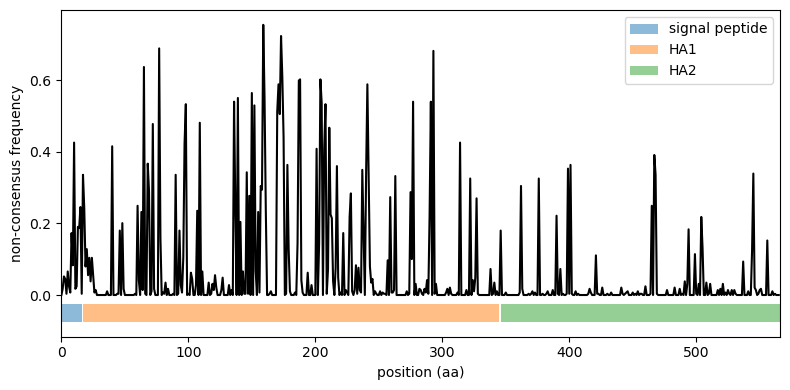

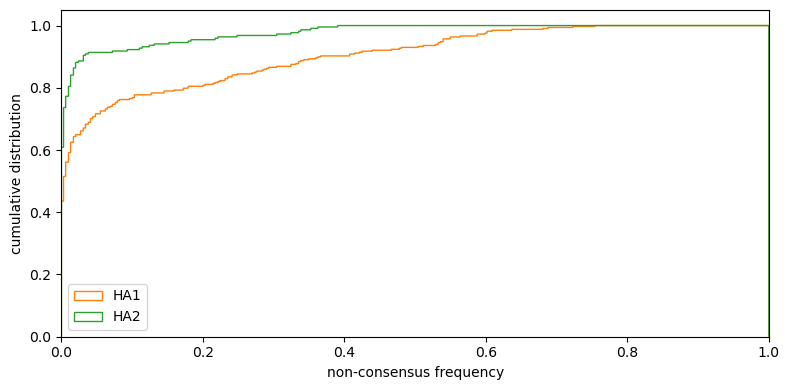

In [49]:
nc_aa_freq = non_consensus_frequency(aa_aln)
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(nc_aa_freq, "k-")
coordinates = {
    "signal peptide": (0, 16, "C0"),
    "HA1": (17, 345, "C1"),
    "HA2": (346, 566, "C2"),
}
for label, (start, end, color) in coordinates.items():
    plt.barh(
        y=-0.05,
        width=end - start,
        left=start,
        height=0.05,
        alpha=0.5,
        label=label,
    )
plt.xlim(0, len(nc_aa_freq))
plt.legend()
plt.xlabel("position (aa)")
plt.ylabel("non-consensus frequency")
plt.tight_layout()
plt.show()

# histogram of diversity in the HA1 vs HA2 regions
fig, ax = plt.subplots(figsize=(8, 4))
for label, (start, end, color) in coordinates.items():
    if label == "signal peptide":
        continue
    plt.hist(
        nc_aa_freq[start:end],
        bins=np.linspace(0, 1, 1000),
        color=color,
        histtype="step",
        label=label,
        cumulative=True,
        density=True,
    )
plt.legend()
plt.xlabel("non-consensus frequency")
plt.ylabel("cumulative distribution")
plt.xlim(0, 1)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()